## Libraries

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## EDA

In [539]:
columns = ['VendorName', 'ModelName', 'MYCT', 'MMIN', 'MMAX', 
           'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df = pd.read_csv('machine.data', names=columns)

print(f"\nDataset shape: {df.shape}")
print(f"Number of instances: {len(df)}")
print(f"\nFirst few rows:")
print(df.head())


Dataset shape: (209, 10)
Number of instances: 209

First few rows:
  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132


In [540]:
print(f"\nBasic statistics:")
print(df.describe())


Basic statistics:
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.0

In [541]:
print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())


Data types:
VendorName    object
ModelName     object
MYCT           int64
MMIN           int64
MMAX           int64
CACH           int64
CHMIN          int64
CHMAX          int64
PRP            int64
ERP            int64
dtype: object

Missing values:
VendorName    0
ModelName     0
MYCT          0
MMIN          0
MMAX          0
CACH          0
CHMIN         0
CHMAX         0
PRP           0
ERP           0
dtype: int64


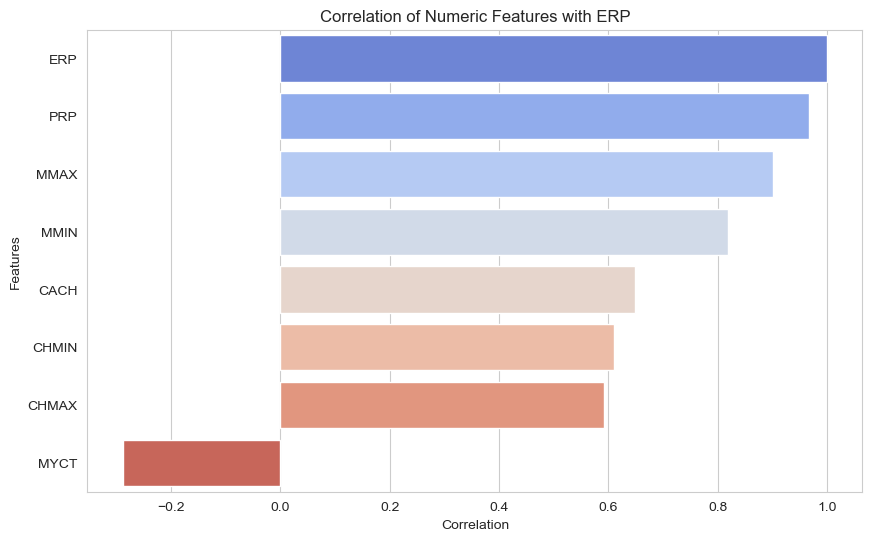

In [542]:
# Select numeric columns
numeric_data = df.select_dtypes(include=[np.number])

# Compute correlations with target 'ERP'
correlations = numeric_data.corr()['ERP'].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation of Numeric Features with ERP')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [543]:
# Show unique vendors
print(f"\nCategorical Features:")
print(f"  Number of unique vendors: {df['VendorName'].nunique()}")
print(f"  Number of unique models: {df['ModelName'].nunique()}")


Categorical Features:
  Number of unique vendors: 30
  Number of unique models: 209


In [544]:
# Drop ModelName (too many unique values, not useful for prediction)
df = df.drop('ModelName', axis=1)

## Data Preparation

In [545]:
# Separate target and predictors
y = df['ERP']
X = df.drop('ERP', axis=1)

In [546]:
# Encode VendorName using one-hot encoding (drop_first to avoid multicollinearity)
X = pd.get_dummies(X, columns=['VendorName'], drop_first=True)
print(f"\nFeatures after encoding: {X.shape[1]}")


Features after encoding: 36


In [547]:
# Split into train/test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [548]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 167
Test set size: 42


In [549]:
# Identify numeric columns for scaling
numeric_cols = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP']

In [550]:
# Standardize numeric features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
# Ensure all columns are numeric (convert boolean to int)
X_train_scaled = X_train_scaled.astype(float)
X_test_scaled = X_test_scaled.astype(float)

## Baseline Model

In [551]:
# Baseline: Always predict the mean of training set
y_pred_baseline = np.full(len(y_test), y_train.mean())
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

In [552]:
print(f"\nBaseline (always predict mean = {y_train.mean():.2f}):")
print(f"  MSE:  {mse_baseline:.2f}")
print(f"  RMSE: {rmse_baseline:.2f}")
print(f"  MAE:  {mae_baseline:.2f}")
print(f"  R²:   {r2_baseline:.3f}")


Baseline (always predict mean = 92.23):
  MSE:  55006.15
  RMSE: 234.53
  MAE:  111.11
  R²:   -0.023


 ## Single Predictor Regression 

In [553]:
# Using statsmodels to get detailed statistics 
X_single_train = sm.add_constant(X_train_scaled[['MYCT']])
model_single = sm.OLS(y_train, X_single_train).fit()

In [554]:
print("\nStatsmodels OLS Regression Summary:")
print(model_single.summary())


Statsmodels OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    ERP   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     17.70
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           4.23e-05
Time:                        18:29:20   Log-Likelihood:                -1037.1
No. Observations:                 167   AIC:                             2078.
Df Residuals:                     165   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         9

In [555]:
# Predict on test set
X_single_test = sm.add_constant(X_test_scaled[['MYCT']])
y_pred_single = model_single.predict(X_single_test)

In [556]:
# Calculate TEST metrics
rss_test_single = np.sum((y_test - y_pred_single)**2)
rmse_test_single = np.sqrt(np.mean((y_test - y_pred_single)**2))
r2_single = r2_score(y_test, y_pred_single)
corr_single = np.corrcoef(y_test, y_pred_single)[0, 1]
mae_single = mean_absolute_error(y_test, y_pred_single)

In [557]:
# Calculate TRAINING RSE (correct way)
y_pred_train_single = model_single.predict(X_single_train)
rss_train_single = np.sum((y_train - y_pred_train_single)**2)
rse_single = np.sqrt(rss_train_single / (len(y_train) - 2))

In [558]:
print("\n" + "-"*70)
print("SINGLE PREDICTOR REGRESSION METRICS:")
print("-"*70)
print(f"  Coefficient (β₁): {model_single.params['MYCT']:.4f}")
print(f"  Intercept (β₀):   {model_single.params['const']:.4f}")
print(f"  t-statistic:      {model_single.tvalues['MYCT']:.4f}")
print(f"  p-value:          {model_single.pvalues['MYCT']:.6f}")
print(f"\n  Training Metrics:")
print(f"    RSS:  {rss_train_single:.2f}")
print(f"    RSE:  {rse_single:.2f}")
print(f"\n  Test Metrics:")
print(f"    RSS:  {rss_test_single:.2f}")
print(f"    RMSE: {rmse_test_single:.2f}")
print(f"    R²:   {r2_single:.3f}")
print(f"    MAE:  {mae_single:.2f}")
print(f"    Correlation (r): {corr_single:.3f}")


----------------------------------------------------------------------
SINGLE PREDICTOR REGRESSION METRICS:
----------------------------------------------------------------------
  Coefficient (β₁): -39.4467
  Intercept (β₀):   92.2275
  t-statistic:      -4.2075
  p-value:          0.000042

  Training Metrics:
    RSS:  2421976.84
    RSE:  121.16

  Test Metrics:
    RSS:  2162468.04
    RMSE: 226.91
    R²:   0.042
    MAE:  106.29
    Correlation (r): 0.289


In [559]:
# Interpretation
print("\n Interpretation:")
if model_single.pvalues['MYCT'] < 0.05:
    print(f"   ✓ MYCT is statistically significant (p < 0.05)")
else:
    print(f"   ✗ MYCT is NOT statistically significant (p ≥ 0.05)")


 Interpretation:
   ✓ MYCT is statistically significant (p < 0.05)


## Multiple Regression

In [560]:
# Using statsmodels for detailed statistics
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)
model_multi_sm = sm.OLS(y_train, X_train_sm).fit()

In [561]:
print("\nStatsmodels Multiple Regression Summary:")
print(model_multi_sm.summary())


Statsmodels Multiple Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    ERP   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     107.4
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           1.67e-80
Time:                        18:29:21   Log-Likelihood:                -762.45
No. Observations:                 167   AIC:                             1597.
Df Residuals:                     131   BIC:                             1709.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [562]:
# Also fit with sklearn for consistency
lr_multi = LinearRegression()
lr_multi.fit(X_train_scaled, y_train)
y_pred_multi = lr_multi.predict(X_test_scaled)

In [563]:
# Calculate TEST metrics
rss_test_multi = np.sum((y_test - y_pred_multi)**2)
rmse_test_multi = np.sqrt(np.mean((y_test - y_pred_multi)**2))
r2_multi = r2_score(y_test, y_pred_multi)
mae_multi = mean_absolute_error(y_test, y_pred_multi)

# Calculate TRAINING RSE (correct way - use statsmodels fitted values)
rss_train_multi = np.sum((y_train - model_multi_sm.fittedvalues)**2)
n_train = len(y_train)
p_multi = X_train_scaled.shape[1]
rse_multi = np.sqrt(rss_train_multi / (n_train - p_multi - 1))

In [564]:
print("\n" + "-"*70)
print("MULTIPLE REGRESSION METRICS:")
print("-"*70)
print(f"  Training Metrics:")
print(f"    RSS (train): {rss_train_multi:.2f}")
print(f"    RSE (train): {rse_multi:.2f}")
print(f"\n  Test Metrics:")
print(f"    RSS (test):  {rss_test_multi:.2f}")
print(f"    RMSE (test): {rmse_test_multi:.2f}")
print(f"    R² (test):   {r2_multi:.3f}")
print(f"    MAE (test):  {mae_multi:.2f}")


----------------------------------------------------------------------
MULTIPLE REGRESSION METRICS:
----------------------------------------------------------------------
  Training Metrics:
    RSS (train): 90329.28
    RSE (train): 26.36

  Test Metrics:
    RSS (test):  120110.67
    RMSE (test): 53.48
    R² (test):   0.947
    MAE (test):  24.98


## Answer Project Questions

In [565]:
# Question 2a: Is at least one predictor useful?
f_statistic = model_multi_sm.fvalue
f_pvalue = model_multi_sm.f_pvalue
print(f"\n2a) Is at least one predictor useful?")
print(f"    F-statistic: {f_statistic:.2f}")
print(f"    F-test p-value: {f_pvalue:.2e}")
if f_pvalue < 0.05:
    print(f"    ✓ YES - At least one predictor is useful (p < 0.05)")
else:
    print(f"    ✗ NO - Predictors may not be useful (p ≥ 0.05)")


2a) Is at least one predictor useful?
    F-statistic: 107.38
    F-test p-value: 1.67e-80
    ✓ YES - At least one predictor is useful (p < 0.05)


In [566]:
# Question 2b: Which predictors are useful?
print(f"\n2b) Do all predictors help, or only a subset?")
significant_vars = model_multi_sm.pvalues[model_multi_sm.pvalues < 0.05]
print(f"\n    Significant predictors (p < 0.05):")
for var, pval in significant_vars.items():
    if var != 'const':
        print(f"      - {var:20s}: p = {pval:.4f}")


2b) Do all predictors help, or only a subset?

    Significant predictors (p < 0.05):
      - MYCT                : p = 0.0003
      - MMIN                : p = 0.0342
      - MMAX                : p = 0.0000
      - CACH                : p = 0.0000
      - PRP                 : p = 0.0000


In [567]:
non_significant_vars = model_multi_sm.pvalues[model_multi_sm.pvalues >= 0.05]
print(f"\n    Non-significant predictors (p ≥ 0.05):")
for var, pval in non_significant_vars.items():
    if var != 'const':
        print(f"      - {var:20s}: p = {pval:.4f}")


    Non-significant predictors (p ≥ 0.05):
      - CHMIN               : p = 0.0854
      - CHMAX               : p = 0.5578
      - VendorName_amdahl   : p = 0.3348
      - VendorName_apollo   : p = 0.5537
      - VendorName_basf     : p = 0.9939
      - VendorName_bti      : p = 0.2988
      - VendorName_burroughs: p = 0.4330
      - VendorName_c.r.d    : p = 0.5126
      - VendorName_cambex   : p = 0.4099
      - VendorName_cdc      : p = 0.6951
      - VendorName_dec      : p = 0.6607
      - VendorName_dg       : p = 0.6918
      - VendorName_formation: p = 0.7326
      - VendorName_four-phase: p = 0.2918
      - VendorName_gould    : p = 0.4727
      - VendorName_harris   : p = 0.5918
      - VendorName_honeywell: p = 0.5265
      - VendorName_hp       : p = 0.3243
      - VendorName_ibm      : p = 0.7013
      - VendorName_ipl      : p = 0.7260
      - VendorName_magnuson : p = 0.3684
      - VendorName_microdata: p = 0.3608
      - VendorName_nas      : p = 0.7358
      - Vend

In [568]:
# Question 2c: How well does the model fit?
print(f"\n2c) How well does the model fit the data?")
print(f"    R²: {r2_multi:.3f} ({r2_multi*100:.1f}% of variance explained)")
print(f"    Adjusted R²: {model_multi_sm.rsquared_adj:.3f}")
print(f"    RSE: {rmse_test_multi:.2f}")


2c) How well does the model fit the data?
    R²: 0.947 (94.7% of variance explained)
    Adjusted R²: 0.957
    RSE: 53.48


In [569]:
# Question 2d: Prediction accuracy
print(f"\n2d) How accurate are our predictions?")
print(f"    Mean Absolute Error: {mae_multi:.2f}")
print(f"    Root Mean Squared Error: {rmse_test_multi:.2f}")
print(f"    R² Score: {r2_multi:.3f}")


2d) How accurate are our predictions?
    Mean Absolute Error: 24.98
    Root Mean Squared Error: 53.48
    R² Score: 0.947


## Multicollinearity Check (VIF)

In [570]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) 
                   for i in range(X_train_scaled.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

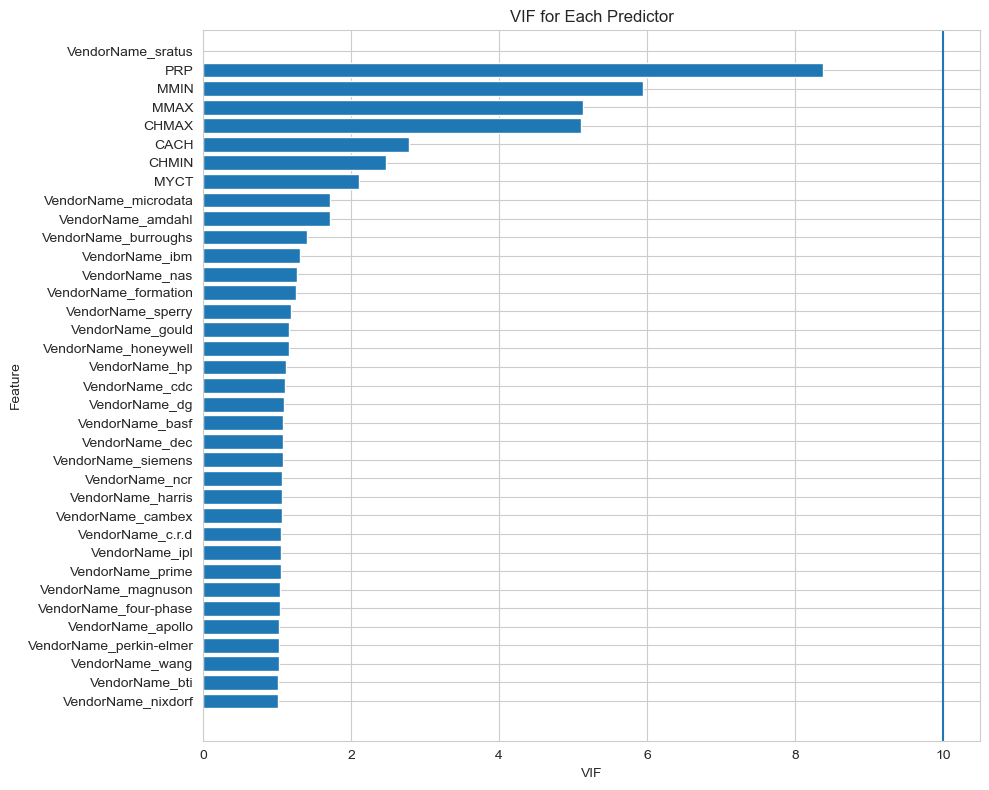

In [571]:
# Sort by VIF (highest first)
vif_sorted = vif_data.sort_values(by='VIF', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(vif_sorted['Feature'], vif_sorted['VIF'])
plt.axvline(x=10)  # Multicollinearity threshold
plt.title('VIF for Each Predictor')
plt.xlabel('VIF')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [572]:
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n  Warning: {len(high_vif)} features have VIF > 10:")
    print(high_vif.to_string(index=False))

## Polynomial Regression

In [573]:
# Try polynomial degrees 2 and 3
results_poly = {}

for degree in [2, 3]:
    print(f"\n--- Polynomial Degree {degree} (MYCT) ---")
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled[['MYCT']])
    X_test_poly = poly.transform(X_test_scaled[['MYCT']])
    
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)
    y_pred_poly = lr_poly.predict(X_test_poly)
    
    # Test metrics
    rss_test_poly = np.sum((y_test - y_pred_poly)**2)
    rmse_test_poly = np.sqrt(np.mean((y_test - y_pred_poly)**2))
    r2_poly = r2_score(y_test, y_pred_poly)
    mae_poly = mean_absolute_error(y_test, y_pred_poly)
    
    # Training RSE 
    y_pred_train_poly = lr_poly.predict(X_train_poly)
    rss_train_poly = np.sum((y_train - y_pred_train_poly)**2)
    rse_poly = np.sqrt(rss_train_poly / (len(y_train) - X_train_poly.shape[1] - 1))
    
    results_poly[degree] = {
        'model': lr_poly,
        'y_pred': y_pred_poly,
        'rss_test': rss_test_poly,
        'rmse_test': rmse_test_poly,
        'rss_train': rss_train_poly,
        'rse': rse_poly,
        'r2': r2_poly,
        'mae': mae_poly
    }
    
    print(f"  Coefficients: {lr_poly.coef_}")
    print(f"  Intercept: {lr_poly.intercept_:.3f}")
    print(f"  Training:")
    print(f"    RSS: {rss_train_poly:.2f}")
    print(f"    RSE: {rse_poly:.2f}")
    print(f"  Test:")
    print(f"    RMSE: {rmse_test_poly:.2f}")
    print(f"    R²:   {r2_poly:.3f}")
    print(f"    MAE:  {mae_poly:.2f}")


--- Polynomial Degree 2 (MYCT) ---
  Coefficients: [-100.03362923   23.4461228 ]
  Intercept: 68.781
  Training:
    RSS: 2196830.23
    RSE: 115.74
  Test:
    RMSE: 220.05
    R²:   0.099
    MAE:  105.15

--- Polynomial Degree 3 (MYCT) ---
  Coefficients: [-144.35242404   94.76017186  -13.81668323]
  Intercept: 33.171
  Training:
    RSS: 1976389.41
    RSE: 110.11
  Test:
    RMSE: 212.67
    R²:   0.159
    MAE:  103.79


## Interaction Terms

In [574]:
# Create interaction terms between VendorName dummy variables and MYCT
X_train_inter = X_train_scaled.copy()
X_test_inter = X_test_scaled.copy()

In [575]:
interaction_cols = [col for col in X_train_scaled.columns if col.startswith('VendorName_')]
print(f"\nCreating {len(interaction_cols)} interaction terms...")


Creating 29 interaction terms...


In [576]:
for col in interaction_cols:
    X_train_inter[f"{col}_x_MYCT"] = X_train_inter[col] * X_train_inter['MYCT']
    X_test_inter[f"{col}_x_MYCT"] = X_test_inter[col] * X_test_inter['MYCT']

In [577]:
print(f"Total features with interactions: {X_train_inter.shape[1]}")

Total features with interactions: 65


In [578]:
# Fit model with interactions
lr_multi_inter = LinearRegression()
lr_multi_inter.fit(X_train_inter, y_train)
y_pred_multi_inter = lr_multi_inter.predict(X_test_inter)

In [579]:
# Calculate TEST metrics
r2_multi_inter = r2_score(y_test, y_pred_multi_inter)
mae_multi_inter = mean_absolute_error(y_test, y_pred_multi_inter)
rss_test_inter = np.sum((y_test - y_pred_multi_inter)**2)
rmse_test_inter = np.sqrt(np.mean((y_test - y_pred_multi_inter)**2))

# Calculate TRAINING RSE (correct way)
y_pred_train_inter = lr_multi_inter.predict(X_train_inter)
rss_train_inter = np.sum((y_train - y_pred_train_inter)**2)
rse_multi_inter = np.sqrt(rss_train_inter / (len(y_train) - X_train_inter.shape[1] - 1))

In [580]:
print(f"\nMultiple Regression WITH Interactions:")
print(f"  Training:")
print(f"    RSE:  {rse_multi_inter:.2f}")
print(f"  Test:")
print(f"    R²:   {r2_multi_inter:.3f}")
print(f"    RMSE: {rmse_test_inter:.2f}")
print(f"    MAE:  {mae_multi_inter:.2f}")

print(f"\nMultiple Regression WITHOUT Interactions:")
print(f"  Training:")
print(f"    RSE:  {rse_multi:.2f}")
print(f"  Test:")
print(f"    R²:   {r2_multi:.3f}")
print(f"    RMSE: {rmse_test_multi:.2f}")
print(f"    MAE:  {mae_multi:.2f}")

improvement = (r2_multi_inter - r2_multi) * 100
print(f"\nR² improvement with interactions: {improvement:+.2f}%")


Multiple Regression WITH Interactions:
  Training:
    RSE:  26.81
  Test:
    R²:   0.948
    RMSE: 52.79
    MAE:  22.75

Multiple Regression WITHOUT Interactions:
  Training:
    RSE:  26.36
  Test:
    R²:   0.947
    RMSE: 53.48
    MAE:  24.98

R² improvement with interactions: +0.14%


## Cross-Validation

In [581]:
models_for_cv = {
    'Multiple Regression': LinearRegression(),
    'Multiple + Interactions': LinearRegression()
}

In [582]:
X_full = pd.get_dummies(df.drop('ERP', axis=1), columns=['VendorName'], drop_first=True)
X_full_scaled = X_full.copy()
X_full_scaled[numeric_cols] = scaler.fit_transform(X_full[numeric_cols])

In [583]:
# Add interactions for second model
X_full_inter = X_full_scaled.copy()
for col in interaction_cols:
    if col in X_full_inter.columns:
        X_full_inter[f"{col}_x_MYCT"] = X_full_inter[col] * X_full_inter['MYCT']

In [584]:
cv_datasets = {
    'Multiple Regression': X_full_scaled,
    'Multiple + Interactions': X_full_inter
}

In [585]:
for model_name, model in models_for_cv.items():
    cv_scores = cross_val_score(model, cv_datasets[model_name], y, 
                                cv=5, scoring='r2')
    print(f"\n{model_name}:")
    print(f"  CV R² scores: {[f'{s:.3f}' for s in cv_scores]}")
    print(f"  Mean CV R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")


Multiple Regression:
  CV R² scores: ['0.868', '0.052', '-0.039', '0.150', '0.857']
  Mean CV R²: 0.378 (±0.400)

Multiple + Interactions:
  CV R² scores: ['0.867', '-12.314', '-10.207', '0.511', '0.927']
  Mean CV R²: -4.043 (±5.932)


## Error Analysis

In [586]:
# Analyze errors from best model (multiple regression with interactions)
errors = np.abs(y_test - y_pred_multi_inter)
residuals = y_test - y_pred_multi_inter

In [587]:
print(f"\nError Statistics:")
print(f"  Mean Absolute Error: {errors.mean():.2f}")
print(f"  Median Absolute Error: {np.median(errors):.2f}")
print(f"  Max Error: {errors.max():.2f}")
print(f"  Min Error: {errors.min():.2f}")


Error Statistics:
  Mean Absolute Error: 22.75
  Median Absolute Error: 10.83
  Max Error: 291.63
  Min Error: 0.01


In [588]:
# Convert predictions to Series with same index as y_test for easier alignment
y_pred_multi_inter_series = pd.Series(y_pred_multi_inter, index=y_test.index)

In [589]:
# Identify worst predictions
worst_idx = errors.nlargest(5).index
print(f"\nWorst 5 Predictions:")
worst_predictions = pd.DataFrame({
    'Actual': y_test.loc[worst_idx].values,
    'Predicted': y_pred_multi_inter_series.loc[worst_idx].values,
    'Error': errors.loc[worst_idx].values,
    'Pct_Error': (errors.loc[worst_idx] / y_test.loc[worst_idx] * 100).values
})
print(worst_predictions.to_string())


Worst 5 Predictions:
   Actual   Predicted       Error   Pct_Error
0    1238  946.369469  291.630531   23.556586
1     919  790.727986  128.272014   13.957782
2      41  -34.943533   75.943533  185.228129
3     341  301.115421   39.884579   11.696358
4      30   -5.427249   35.427249  118.090829


In [590]:
# Best predictions
best_idx = errors.nsmallest(5).index
print(f"\nBest 5 Predictions:")
best_predictions = pd.DataFrame({
    'Actual': y_test.loc[best_idx].values,
    'Predicted': y_pred_multi_inter_series.loc[best_idx].values,
    'Error': errors.loc[best_idx].values,
    'Pct_Error': (errors.loc[best_idx] / y_test.loc[best_idx] * 100).values
})
print(best_predictions.to_string())


Best 5 Predictions:
   Actual  Predicted     Error  Pct_Error
0      41  41.012025  0.012025   0.029330
1      26  26.424261  0.424261   1.631772
2      34  33.500137  0.499863   1.470185
3      25  23.948903  1.051097   4.204387
4      33  31.557294  1.442706   4.371837


## Model Comparison Summary

In [591]:
results_summary = pd.DataFrame({
    'Model': [
        'Baseline (Mean)',
        'Single Predictor (MYCT)',
        'Multiple Regression',
        'Polynomial Deg 2',
        'Polynomial Deg 3',
        'Multiple + Interactions'
    ],
    'R²': [
        r2_baseline,
        r2_single,
        r2_multi,
        results_poly[2]['r2'],
        results_poly[3]['r2'],
        r2_multi_inter
    ],
    'MAE': [
        mae_baseline,
        mae_single,
        mae_multi,
        results_poly[2]['mae'],
        results_poly[3]['mae'],
        mae_multi_inter
    ],
    'RSE': [
        rmse_baseline,
        rmse_test_single,
        rmse_test_multi,
        results_poly[2]['rmse_test'],
        results_poly[3]['rmse_test'],
        rmse_test_inter
    ]
})

In [592]:
results_summary = results_summary.sort_values('R²', ascending=False)
print("\n" + results_summary.to_string(index=False))


                  Model        R²        MAE        RSE
Multiple + Interactions  0.948159  22.748137  52.790379
    Multiple Regression  0.946802  24.980606  53.476892
       Polynomial Deg 3  0.158622 103.786201 212.673261
       Polynomial Deg 2  0.099250 105.153748 220.049010
Single Predictor (MYCT)  0.042220 106.287874 226.908207
        Baseline (Mean) -0.023238 111.108355 234.533898


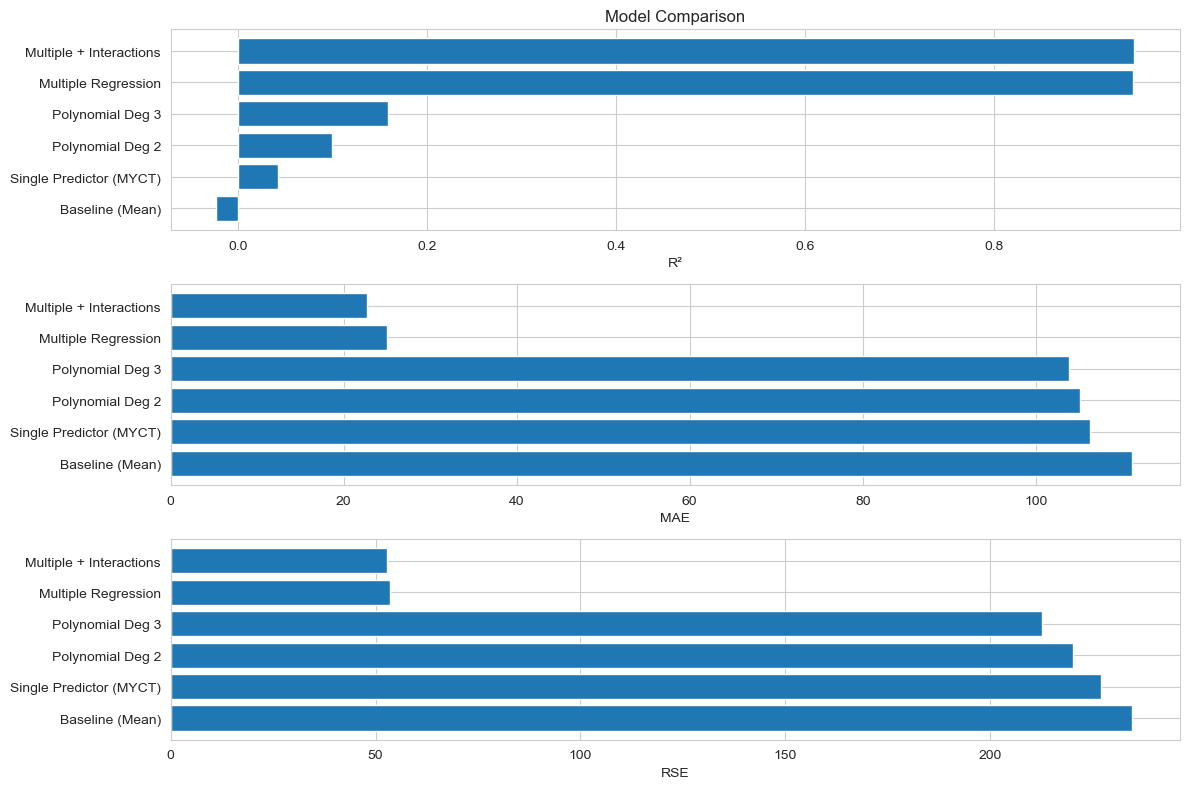

In [593]:
# Sort best → worst by R²
results_sorted = results_summary.sort_values('R²', ascending=True)

models = results_sorted['Model']

plt.figure(figsize=(12,8))

# --- R² ---
plt.subplot(3,1,1)
plt.barh(models, results_sorted['R²'])
plt.title('Model Comparison')
plt.xlabel('R²')

# --- MAE ---
plt.subplot(3,1,2)
plt.barh(models, results_sorted['MAE'])
plt.xlabel('MAE')

# --- RSE ---
plt.subplot(3,1,3)
plt.barh(models, results_sorted['RSE'])
plt.xlabel('RSE')

plt.tight_layout()
plt.show()

In [594]:
best_model = results_summary.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model}")
print(f"   R² = {results_summary.iloc[0]['R²']:.3f}")


🏆 Best Model: Multiple + Interactions
   R² = 0.948


## Prediction on New Hardware

In [595]:
new_hardware = pd.DataFrame({
    'MYCT': [200],
    'MMIN': [4096],
    'MMAX': [16384],
    'CACH': [64],
    'CHMIN': [2],
    'CHMAX': [16],
    'PRP': [150],
})

print("\nNew Hardware Specifications:")
print(new_hardware.to_string(index=False))


New Hardware Specifications:
 MYCT  MMIN  MMAX  CACH  CHMIN  CHMAX  PRP
  200  4096 16384    64      2     16  150


In [596]:
# Create a copy for processing
new_hardware_processed = new_hardware.copy()

# Add ALL missing columns from X_train_inter with 0 (assuming unknown vendor)
for col in X_train_inter.columns:
    if col not in new_hardware_processed.columns:
        new_hardware_processed[col] = 0

In [597]:
# Reorder columns to match training data exactly
new_hardware_processed = new_hardware_processed[X_train_inter.columns]

# Scale numeric columns (create temporary df for scaling)
new_hardware_to_scale = new_hardware.copy()
new_hardware_processed[numeric_cols] = scaler.transform(new_hardware_to_scale[numeric_cols])

# Recreate interaction terms with scaled values
interaction_cols_list = [col for col in X_train_inter.columns if col.startswith('VendorName_') and not col.endswith('_x_MYCT')]
for col in interaction_cols_list:
    if f"{col}_x_MYCT" in X_train_inter.columns:
        new_hardware_processed[f"{col}_x_MYCT"] = new_hardware_processed[col] * new_hardware_processed['MYCT']

In [598]:
# Predict using best model (sklearn)
predicted_erp = lr_multi_inter.predict(new_hardware_processed)

print(f"\n📊 Predicted ERP (Estimated Relative Performance): {predicted_erp[0]:.2f}")


📊 Predicted ERP (Estimated Relative Performance): 84.37


In [599]:
# Get residuals from training data
residuals_inter = y_train.values - lr_multi_inter.predict(X_train_inter)

# Calculate residual standard error (RSE)
n = len(y_train)
p = X_train_inter.shape[1]
rse = np.sqrt(np.sum(residuals_inter**2) / (n - p - 1))

# For a new prediction, the standard error includes:
# 1. Uncertainty in the coefficient estimates
# 2. Inherent variability in the response
# Standard formula: SE = RSE * sqrt(1 + 1/n + (x-x_bar)^T * (X^T*X)^-1 * (x-x_bar))
# Simplified approximation: SE ≈ RSE * sqrt(1 + 1/n)

se_pred = rse * np.sqrt(1 + 1/n)

In [600]:
# 95% prediction interval (using t-distribution)
df = n - p - 1  # degrees of freedom
t_value = stats.t.ppf(0.975, df=df)  # 97.5th percentile for 95% two-sided interval

lower_bound = predicted_erp[0] - t_value * se_pred
upper_bound = predicted_erp[0] + t_value * se_pred

In [601]:
# Calculate prediction interval using proper statistical method
print(f"\n95% Prediction Interval:")
print(f"  Point estimate: {predicted_erp[0]:.2f}")
print(f"  Lower bound:    {max(0, lower_bound):.2f}")  # ERP can't be negative
print(f"  Upper bound:    {upper_bound:.2f}")
print(f"  Interval width: {upper_bound - max(0, lower_bound):.2f}")
print(f"  Confidence:     95%")
print(f"\n  📝 Interpretation:")
print(f"     We are 95% confident that a machine with these specifications")
print(f"     will have an ERP between {max(0, lower_bound):.2f} and {upper_bound:.2f}.")


95% Prediction Interval:
  Point estimate: 84.37
  Lower bound:    31.03
  Upper bound:    137.71
  Interval width: 106.67
  Confidence:     95%

  📝 Interpretation:
     We are 95% confident that a machine with these specifications
     will have an ERP between 31.03 and 137.71.


## Visualizations

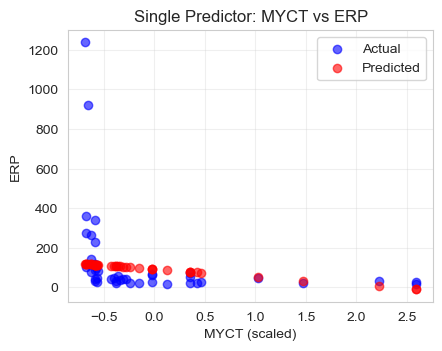

In [602]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Single Predictor: MYCT vs ERP
ax1 = plt.subplot(3, 3, 1)
plt.scatter(X_test_scaled['MYCT'], y_test, alpha=0.6, label='Actual', color='blue')
plt.scatter(X_test_scaled['MYCT'], y_pred_single, alpha=0.6, label='Predicted', color='red')
plt.xlabel('MYCT (scaled)')
plt.ylabel('ERP')
plt.title('Single Predictor: MYCT vs ERP')
plt.legend()
plt.grid(True, alpha=0.3)

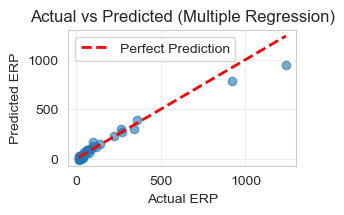

In [603]:
# 2. Actual vs Predicted (Multiple Regression)
ax2 = plt.subplot(3, 3, 2)
plt.scatter(y_test, y_pred_multi, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual ERP')
plt.ylabel('Predicted ERP')
plt.title('Actual vs Predicted (Multiple Regression)')
plt.legend()
plt.grid(True, alpha=0.3)

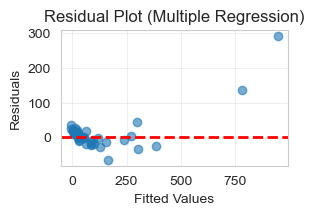

In [604]:
# 3. Residual Plot (Multiple Regression)
ax3 = plt.subplot(3, 3, 3)
residuals_multi = y_test - y_pred_multi
plt.scatter(y_pred_multi, residuals_multi, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Multiple Regression)')
plt.grid(True, alpha=0.3)

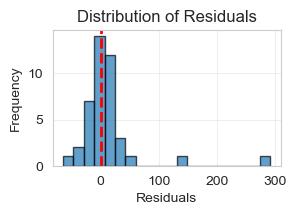

In [605]:
# 4. Distribution of Residuals
ax4 = plt.subplot(3, 3, 4)
plt.hist(residuals_multi, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)

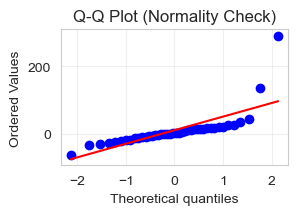

In [606]:
# 5. Q-Q Plot for normality check
ax5 = plt.subplot(3, 3, 5)
from scipy import stats
stats.probplot(residuals_multi, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

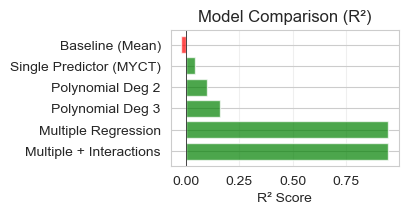

In [607]:
# 6. Model Comparison (R² scores)
ax6 = plt.subplot(3, 3, 6)
models = results_summary['Model'].values
r2_scores = results_summary['R²'].values
colors = ['red' if r2 < 0 else 'green' for r2 in r2_scores]
plt.barh(models, r2_scores, color=colors, alpha=0.7)
plt.xlabel('R² Score')
plt.title('Model Comparison (R²)')
plt.axvline(x=0, color='black', linestyle='-', lw=0.5)
plt.grid(True, alpha=0.3, axis='x')

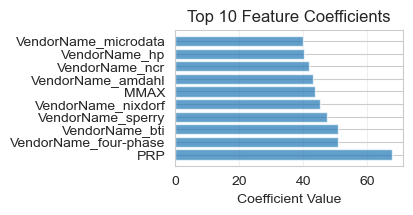

In [608]:
# 7. Feature Importance (Top 10 coefficients from multiple regression)
ax7 = plt.subplot(3, 3, 7)
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_multi.coef_
})
coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coef', ascending=False).head(10)
plt.barh(coef_df['Feature'], coef_df['Coefficient'], alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients')
plt.axvline(x=0, color='black', linestyle='-', lw=0.5)
plt.grid(True, alpha=0.3, axis='x')

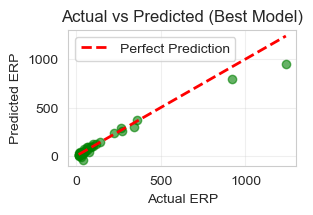

In [609]:
# 8. Actual vs Predicted (Best Model: Multiple + Interactions)
ax8 = plt.subplot(3, 3, 8)
plt.scatter(y_test, y_pred_multi_inter, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual ERP')
plt.ylabel('Predicted ERP')
plt.title('Actual vs Predicted (Best Model)')
plt.legend()
plt.grid(True, alpha=0.3)

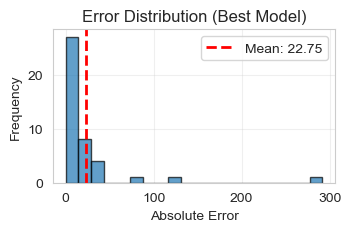

In [610]:
# 9. Error Distribution (Best Model)
ax9 = plt.subplot(3, 3, 9)
errors_best = np.abs(y_test - y_pred_multi_inter)
plt.hist(errors_best, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution (Best Model)')
plt.axvline(x=errors_best.mean(), color='r', linestyle='--', 
            lw=2, label=f'Mean: {errors_best.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

## Reduced Model

In [611]:
print("\nComparing Full Model vs Reduced Model (only significant predictors)")

# Identify significant predictors from the full model
significant_predictors = []
for var in model_multi_sm.pvalues.index:
    if var != 'const' and model_multi_sm.pvalues[var] < 0.05:
        significant_predictors.append(var)

print(f"\nSignificant predictors to keep: {len(significant_predictors)}")
print(f"{significant_predictors}\n")


Comparing Full Model vs Reduced Model (only significant predictors)

Significant predictors to keep: 5
['MYCT', 'MMIN', 'MMAX', 'CACH', 'PRP']



In [612]:
# Create reduced training and test sets
X_train_reduced = X_train_scaled[significant_predictors]
X_test_reduced = X_test_scaled[significant_predictors]

# Fit reduced model
lr_reduced = LinearRegression()
lr_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = lr_reduced.predict(X_test_reduced)

# Calculate metrics for reduced model
r2_reduced = r2_score(y_test, y_pred_reduced)
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)
rss_reduced = np.sum((y_test - y_pred_reduced)**2)
rse_reduced = np.sqrt(rss_reduced / (len(y_test) - X_train_reduced.shape[1] - 1))

# Also get adjusted R² using statsmodels
X_train_reduced_sm = sm.add_constant(X_train_reduced)
model_reduced_sm = sm.OLS(y_train, X_train_reduced_sm).fit()

In [613]:
comparison_df = pd.DataFrame({
    'Metric': ['Number of Features', 'R²', 'Adjusted R²', 'RSE', 'MAE'],
    'Full Model': [
        X_train_scaled.shape[1],
        f"{r2_multi:.4f}",
        f"{model_multi_sm.rsquared_adj:.4f}",
        f"{rmse_test_multi:.4f}",
        f"{mae_multi:.4f}"
    ],
    'Reduced Model': [
        X_train_reduced.shape[1],
        f"{r2_reduced:.4f}",
        f"{model_reduced_sm.rsquared_adj:.4f}",
        f"{rse_reduced:.4f}",
        f"{mae_reduced:.4f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))


            Metric Full Model Reduced Model
Number of Features         36             5
                R²     0.9468        0.9418
       Adjusted R²     0.9573        0.9549
               RSE    53.4769       60.3952
               MAE    24.9806       25.6986


In [614]:
r2_diff = r2_multi - r2_reduced
adj_r2_diff = model_multi_sm.rsquared_adj - model_reduced_sm.rsquared_adj

In [615]:
print(f"\n1. R² Comparison:")
print(f"   Full Model R²:    {r2_multi:.4f}")
print(f"   Reduced Model R²: {r2_reduced:.4f}")
print(f"   Difference:       {r2_diff:.4f} ({r2_diff*100:.2f}%)")

print(f"\n2. Adjusted R² Comparison (accounts for # of predictors):")
print(f"   Full Model Adj R²:    {model_multi_sm.rsquared_adj:.4f}")
print(f"   Reduced Model Adj R²: {model_reduced_sm.rsquared_adj:.4f}")
print(f"   Difference:           {adj_r2_diff:.4f}")

print(f"\n3. Model Complexity:")
print(f"   Full Model:    {X_train_scaled.shape[1]} features")
print(f"   Reduced Model: {X_train_reduced.shape[1]} features")
print(f"   Reduction:     {X_train_scaled.shape[1] - X_train_reduced.shape[1]} features removed")


1. R² Comparison:
   Full Model R²:    0.9468
   Reduced Model R²: 0.9418
   Difference:       0.0050 (0.50%)

2. Adjusted R² Comparison (accounts for # of predictors):
   Full Model Adj R²:    0.9573
   Reduced Model Adj R²: 0.9549
   Difference:           0.0024

3. Model Complexity:
   Full Model:    36 features
   Reduced Model: 5 features
   Reduction:     31 features removed


In [616]:
# Decision
print(f"\n💡 RECOMMENDATION:")
if abs(adj_r2_diff) < 0.01:  # Less than 1% difference
    print(f"   ✓ USE REDUCED MODEL")
    print(f"   Reason: Similar performance ({abs(adj_r2_diff)*100:.2f}% adj R² difference)")
    print(f"   Benefits: Simpler, more interpretable, fewer features")
elif adj_r2_diff > 0.01:  # Full model is better
    print(f"   ✓ USE FULL MODEL")
    print(f"   Reason: Full model has {adj_r2_diff*100:.2f}% higher adjusted R²")
    print(f"   Benefits: Better predictive performance")
else:  # Reduced model is better
    print(f"   ✓ USE REDUCED MODEL")
    print(f"   Reason: Better adjusted R² ({abs(adj_r2_diff)*100:.2f}% higher)")
    print(f"   Benefits: Better performance AND simpler")


💡 RECOMMENDATION:
   ✓ USE REDUCED MODEL
   Reason: Similar performance (0.24% adj R² difference)
   Benefits: Simpler, more interpretable, fewer features


In [617]:
# Statistical test: F-test for nested models
print(f"\n4. Statistical Test (F-test for nested models):")
print(f"   H0: Non-significant predictors collectively add no value")

# Calculate F-statistic for the comparison
rss_full = np.sum((y_train - model_multi_sm.fittedvalues)**2)
rss_reduced = np.sum((y_train - model_reduced_sm.fittedvalues)**2)
df_full = len(y_train) - X_train_scaled.shape[1] - 1
df_reduced = len(y_train) - X_train_reduced.shape[1] - 1
df_diff = X_train_scaled.shape[1] - X_train_reduced.shape[1]

f_stat = ((rss_reduced - rss_full) / df_diff) / (rss_full / df_full)
from scipy import stats
f_pvalue = 1 - stats.f.cdf(f_stat, df_diff, df_full)

print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value:     {f_pvalue:.4f}")

if f_pvalue < 0.05:
    print(f"   Result: REJECT H0 (p < 0.05)")
    print(f"   → Non-significant predictors DO add value to the model")
    print(f"   → Keep the FULL MODEL")
else:
    print(f"   Result: FAIL TO REJECT H0 (p ≥ 0.05)")
    print(f"   → Non-significant predictors do NOT add significant value")
    print(f"   → Use the REDUCED MODEL")



4. Statistical Test (F-test for nested models):
   H0: Non-significant predictors collectively add no value
   F-statistic: 1.2470
   p-value:     0.1967
   Result: FAIL TO REJECT H0 (p ≥ 0.05)
   → Non-significant predictors do NOT add significant value
   → Use the REDUCED MODEL


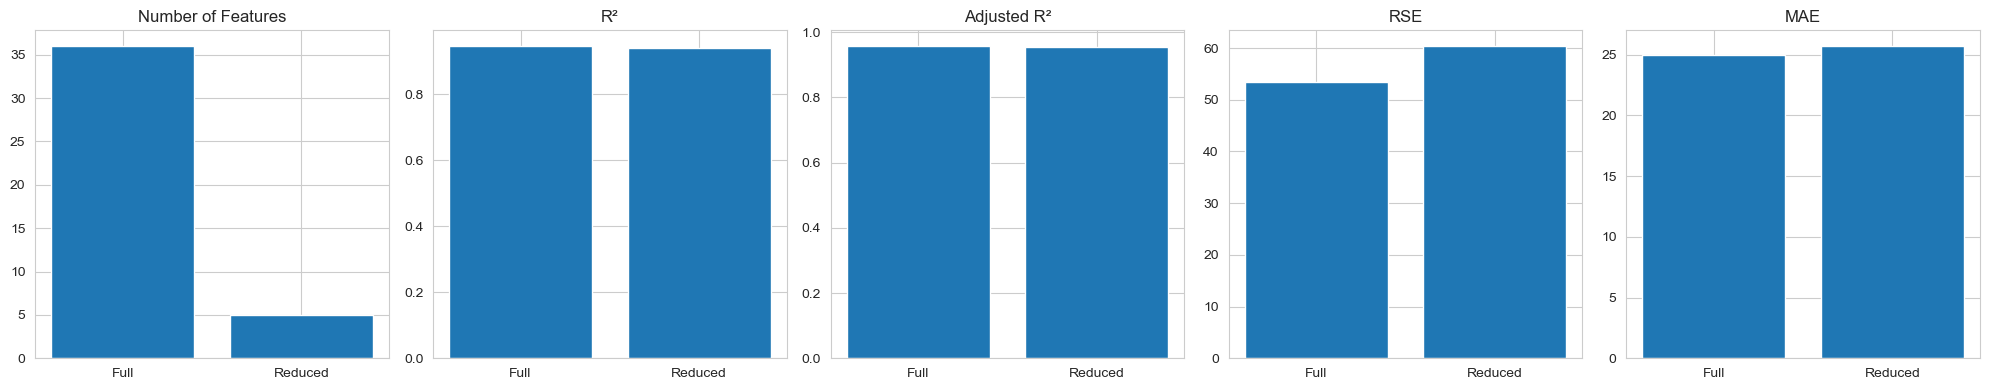

In [618]:
metrics = ['Number of Features', 'R²', 'Adjusted R²', 'RSE', 'MAE']

full_vals = [
    X_train_scaled.shape[1],
    r2_multi,
    model_multi_sm.rsquared_adj,
    rmse_test_multi,
    mae_multi
]

reduced_vals = [
    X_train_reduced.shape[1],
    r2_reduced,
    model_reduced_sm.rsquared_adj,
    rse_reduced,
    mae_reduced
]

fig, axes = plt.subplots(1, 5, figsize=(20,4))

for i, ax in enumerate(axes):
    ax.bar(['Full', 'Reduced'], [full_vals[i], reduced_vals[i]])
    ax.set_title(metrics[i])

plt.tight_layout()
plt.show()